In [7]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [8]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [9]:
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [10]:
data = read_text("/content/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [11]:
deu_eng = deu_eng[:50000,:]

In [12]:
deu_eng

array([['Go.', 'Geh.'],
       ['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ...,
       ["I'm giving up smoking.", 'Ich höre mit dem Rauchen auf.'],
       ["I'm glad I was nearby.",
        'Ich bin froh, dass ich in der Nähe war.'],
       ["I'm glad Tom has gone.", 'Ich bin froh, dass Tom weg ist.']],
      dtype='<U537')

In [13]:
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [14]:
deu_eng

array([['Go', 'Geh'],
       ['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist']],
      dtype='<U537')

In [15]:
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [16]:
deu_eng

array([['go', 'geh'],
       ['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ...,
       ['im giving up smoking', 'ich höre mit dem rauchen auf'],
       ['im glad i was nearby', 'ich bin froh dass ich in der nähe war'],
       ['im glad tom has gone', 'ich bin froh dass tom weg ist']],
      dtype='<U537')

In [17]:
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [18]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

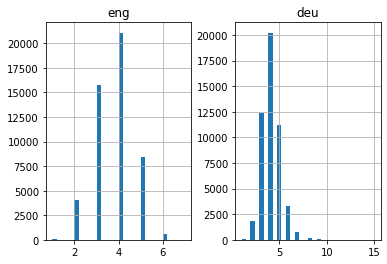

In [19]:
length_df.hist(bins = 30)
plt.show()

In [20]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [21]:
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [22]:
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


In [23]:
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [25]:
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [26]:
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [27]:
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [30]:
filename = 'model.h1.24_feb_16'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/30
63/63 [==============================] - 160s 3s/step - loss: 3.0920 - val_loss: 2.8172

Epoch 00001: val_loss improved from inf to 2.81723, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 2/30
63/63 [==============================] - 158s 3s/step - loss: 2.7477 - val_loss: 2.7178

Epoch 00002: val_loss improved from 2.81723 to 2.71782, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 3/30
63/63 [==============================] - 158s 3s/step - loss: 2.5591 - val_loss: 2.5107

Epoch 00003: val_loss improved from 2.71782 to 2.51073, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 4/30
63/63 [==============================] - 158s 3s/step - loss: 2.3923 - val_loss: 2.4216

Epoch 00004: val_loss improved from 2.51073 to 2.42162, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 5/30
63/63 [==============================] - 158s 3s/step - loss: 2.2476 - val_loss: 2.2746

Epoch 00005: val_loss improved from 2.42162 to 2.27462, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 6/30
63/63 [==============================] - 158s 3s/step - loss: 2.1088 - val_loss: 2.1947

Epoch 00006: val_loss improved from 2.27462 to 2.19472, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 7/30
63/63 [==============================] - 157s 3s/step - loss: 1.9825 - val_loss: 2.1273

Epoch 00007: val_loss improved from 2.19472 to 2.12729, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 8/30
63/63 [==============================] - 158s 3s/step - loss: 1.8659 - val_loss: 2.0149

Epoch 00008: val_loss improved from 2.12729 to 2.01491, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 9/30
63/63 [==============================] - 158s 3s/step - loss: 1.7606 - val_loss: 1.9465

Epoch 00009: val_loss improved from 2.01491 to 1.94654, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 10/30
63/63 [==============================] - 158s 3s/step - loss: 1.6597 - val_loss: 1.8757

Epoch 00010: val_loss improved from 1.94654 to 1.87567, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 11/30
63/63 [==============================] - 158s 3s/step - loss: 1.5634 - val_loss: 1.8040

Epoch 00011: val_loss improved from 1.87567 to 1.80404, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 12/30
63/63 [==============================] - 158s 3s/step - loss: 1.4679 - val_loss: 1.7410

Epoch 00012: val_loss improved from 1.80404 to 1.74101, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 13/30
63/63 [==============================] - 158s 3s/step - loss: 1.3801 - val_loss: 1.6905

Epoch 00013: val_loss improved from 1.74101 to 1.69048, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 14/30
63/63 [==============================] - 158s 3s/step - loss: 1.2949 - val_loss: 1.6465

Epoch 00014: val_loss improved from 1.69048 to 1.64647, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 15/30
63/63 [==============================] - 158s 3s/step - loss: 1.2123 - val_loss: 1.6008

Epoch 00015: val_loss improved from 1.64647 to 1.60076, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 16/30
63/63 [==============================] - 158s 3s/step - loss: 1.1354 - val_loss: 1.5767

Epoch 00016: val_loss improved from 1.60076 to 1.57674, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 17/30
63/63 [==============================] - 158s 3s/step - loss: 1.0608 - val_loss: 1.5272

Epoch 00017: val_loss improved from 1.57674 to 1.52723, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 18/30
63/63 [==============================] - 158s 3s/step - loss: 0.9902 - val_loss: 1.4922

Epoch 00018: val_loss improved from 1.52723 to 1.49222, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 19/30
63/63 [==============================] - 158s 3s/step - loss: 0.9205 - val_loss: 1.4625

Epoch 00019: val_loss improved from 1.49222 to 1.46247, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 20/30
63/63 [==============================] - 158s 3s/step - loss: 0.8560 - val_loss: 1.4426

Epoch 00020: val_loss improved from 1.46247 to 1.44256, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 21/30
63/63 [==============================] - 159s 3s/step - loss: 0.7930 - val_loss: 1.4022

Epoch 00021: val_loss improved from 1.44256 to 1.40217, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 22/30
63/63 [==============================] - 158s 3s/step - loss: 0.7321 - val_loss: 1.3963

Epoch 00022: val_loss improved from 1.40217 to 1.39628, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 23/30
63/63 [==============================] - 158s 3s/step - loss: 0.6805 - val_loss: 1.3786

Epoch 00023: val_loss improved from 1.39628 to 1.37856, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 24/30
63/63 [==============================] - 158s 3s/step - loss: 0.6251 - val_loss: 1.3529

Epoch 00024: val_loss improved from 1.37856 to 1.35288, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 25/30
63/63 [==============================] - 158s 3s/step - loss: 0.5783 - val_loss: 1.3408

Epoch 00025: val_loss improved from 1.35288 to 1.34082, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 26/30
63/63 [==============================] - 158s 3s/step - loss: 0.5312 - val_loss: 1.3342

Epoch 00026: val_loss improved from 1.34082 to 1.33418, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 27/30
63/63 [==============================] - 157s 2s/step - loss: 0.4877 - val_loss: 1.3201

Epoch 00027: val_loss improved from 1.33418 to 1.32005, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 28/30
63/63 [==============================] - 157s 2s/step - loss: 0.4467 - val_loss: 1.3115

Epoch 00028: val_loss improved from 1.32005 to 1.31148, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 29/30
63/63 [==============================] - 158s 3s/step - loss: 0.4093 - val_loss: 1.3048

Epoch 00029: val_loss improved from 1.31148 to 1.30481, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


Epoch 30/30
63/63 [==============================] - 158s 3s/step - loss: 0.3747 - val_loss: 1.3007

Epoch 00030: val_loss improved from 1.30481 to 1.30069, saving model to model.h1.24_feb_16


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


INFO:tensorflow:Assets written to: model.h1.24_feb_16/assets


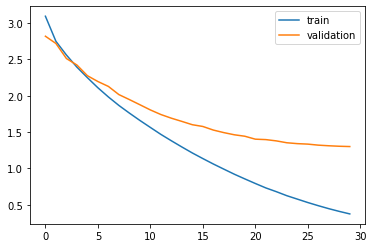

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('model.h1.24_feb_16')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [35]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [36]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [37]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [38]:
pd.set_option('display.max_colwidth', 200)

In [40]:
pred_df.head(25)

,actual,predicted
0,i know that already,i already know that
1,whos she,who is she
2,do you have it,did you have it
3,use your feet,put your shoes
4,that was the trouble,the rang
5,he took off his coat,he put his toys
6,tom went sightseeing,tom wrote the scream
7,i tried on the shoes,i have my shoes
8,open those doors,open the open
9,ive got to help tom,i have help tom


In [41]:
pred_df.tail(25)

,actual,predicted
9975,we need more food,we need more
9976,return at once,come back
9977,watch closely,look closely
9978,it serves you right,you deserve you
9979,dont be a cheapskate,dont be a snob
9980,he is always reading,he is wearing
9981,tom tickled mary,tom threatened mary
9982,did you invite him,did you invite him
9983,stop messing around,stop doing that
9984,is this confusing,that is worked


In [42]:
pred_df.tail(25)

,actual,predicted
9975,we need more food,we need more
9976,return at once,come back
9977,watch closely,look closely
9978,it serves you right,you deserve you
9979,dont be a cheapskate,dont be a snob
9980,he is always reading,he is wearing
9981,tom tickled mary,tom threatened mary
9982,did you invite him,did you invite him
9983,stop messing around,stop doing that
9984,is this confusing,that is worked


In [43]:
pred_df.sample(25)

,actual,predicted
4015,this is not enough,this isnt enough
4022,tom got cheated,tom got hired
9737,wheres your sister,wheres your sister
5521,tom is making faces,tom sells
1935,how do i stop tom,how can i help tom
1440,she sued him,she attacked him
1152,i used to drink beer,i often to beer
2209,did you meet her,did you meet her
1790,were just friends,were just friends
6676,turn back please,please stop please
